In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.3.0


In [ ]:
df = pd.read_csv('/content/drive/My Drive/twitter_posts.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

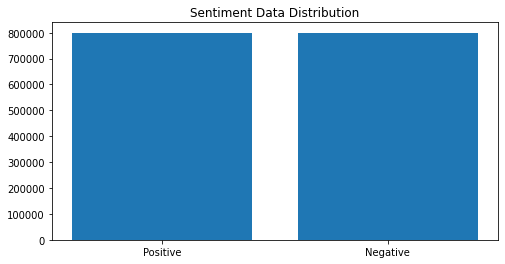

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] 
df.loc[random_idx_list,:].head(10) 

,sentiment,text
216126,Negative,@Kat_KittyKat lol yea I know I hate it....I ha...
567652,Negative,@TheLASIKDoc My eyes are just bad candidates ...
1424854,Positive,@philipstorry - I'm sworn to secrecy on one pa...
1308489,Positive,@xLakeEffectKid if i had the money i'd totally...
1512109,Positive,Alpha mc listening party on Tuesday. Hit me up...
1446320,Positive,Morning from a very wet Barking but smiling fr...
1048325,Positive,"@Nadia_Fly thats 2words of really, and thats o..."
1203312,Positive,Dinner with my dad
786429,Negative,@dah808mike that'll be the day....you'll never...
404396,Negative,Both of my cheeks are swollen idk what he eve...


In [ ]:
df.shape

(1600000, 2)


# Text Preprocessing


In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
df.loc[random_idx_list,:].head(10)

,sentiment,text
216126,Negative,lol yea know hate space runs bit legs shit heheeh
567652,Negative,eyes bad candidates medical issues going away ...
1424854,Positive,sworn secrecy one part tmrw mon part new song ...
1308489,Positive,money totally help pay ticket spain much cost ...
1512109,Positive,alpha mc listening party tuesday hit details p...
1446320,Positive,morning wet barking smiling surprise visit her...
1048325,Positive,thats 2words really thats obviously tired keep...
1203312,Positive,dinner dad
786429,Negative,day never life get beer belly skinny bitch
404396,Negative,cheeks swollen idk even teeth clean fuck bouta...



### Positive Words

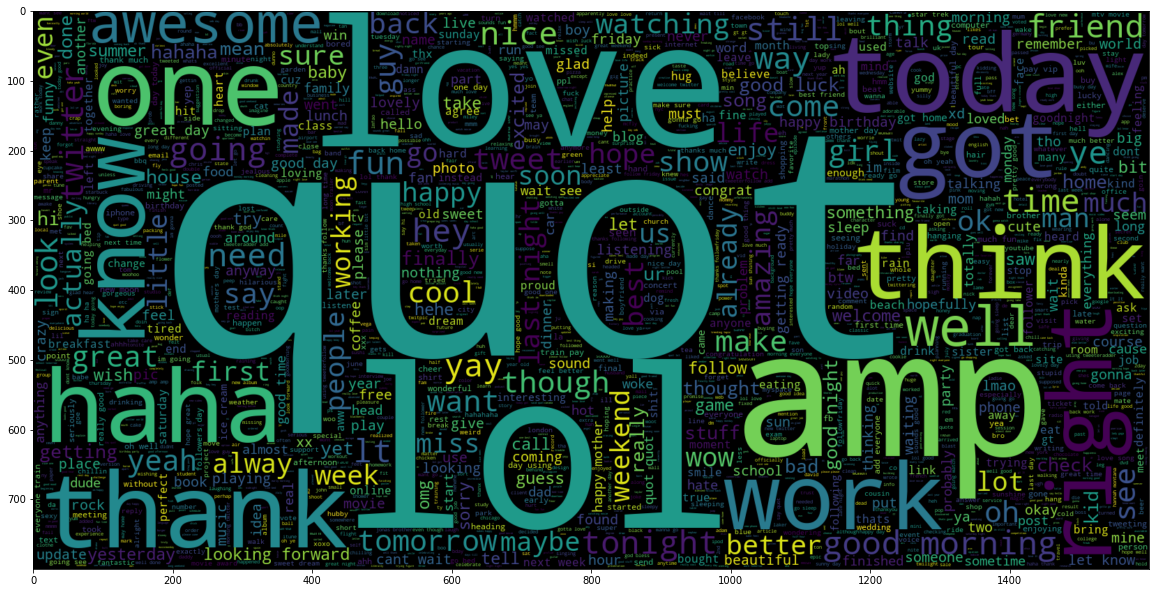

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

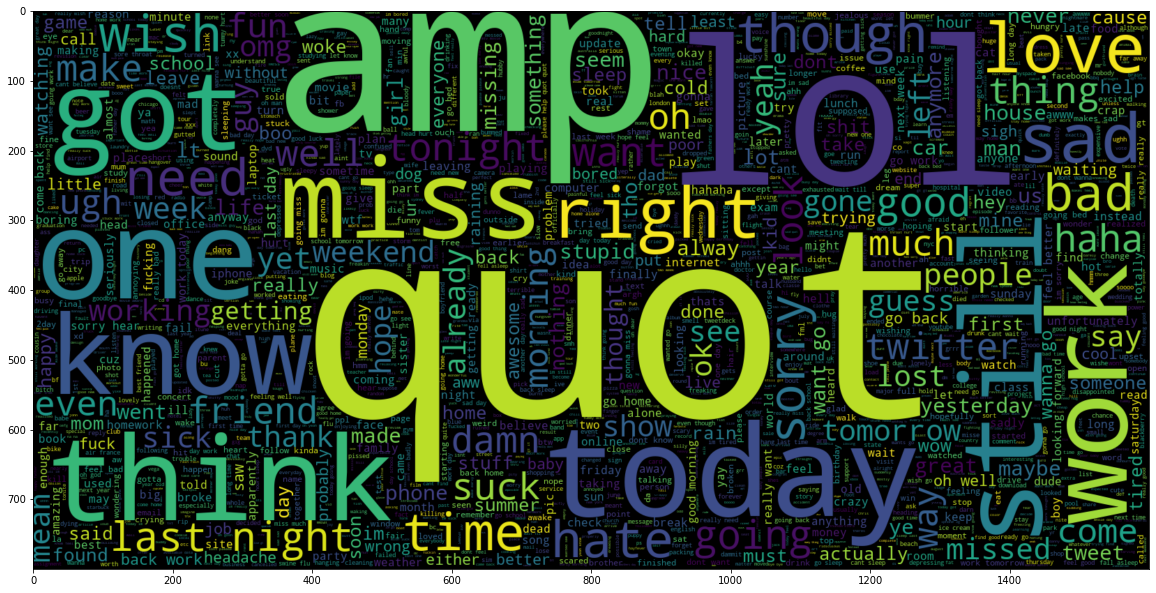

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [ ]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [ ]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [ ]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding 


In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [ ]:
df.shape[0] == y_train.shape[0] + y_test.shape[0]

True

In [ ]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '/content/drive/My Drive/best_model(2).hdf5'

# Model Training - LSTM


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Embedding


In [ ]:

model=Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           87172500  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 87,493,501
Trainable params: 87,493,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 1011s 809ms/step - loss: 0.5575 - accuracy: 0.7369 - val_loss: 0.5118 - val_accuracy: 0.7675
Epoch 2/10
1250/1250 [==============================] - 1010s 808ms/step - loss: 0.5064 - accuracy: 0.7764 - val_loss: 0.4981 - val_accuracy: 0.7798
Epoch 3/10
1250/1250 [==============================] - 1012s 810ms/step - loss: 0.4678 - accuracy: 0.8016 - val_loss: 0.5108 - val_accuracy: 0.7812
Epoch 4/10
1250/1250 [==============================] - 1011s 808ms/step - loss: 0.4896 - accuracy: 0.7894 - val_loss: 0.5156 - val_accuracy: 0.7686
Epoch 5/10
1250/1250 [==============================] - 1010s 808ms/step - loss: 0.4807 - accuracy: 0.7897 - val_loss: 0.5060 - val_accuracy: 0.7781
Epoch 6/10
1250/1250 [==============================] - 1019s 815ms/step - loss: 0.4757 - accuracy: 0.7960 - val_loss: 0.5097 - val_accuracy: 0.7685
Epoch 7/10
1250/1250 [==============================] - 1008s 806ms/step - loss: 0.4550 - accuracy: 0.8078

In [ ]:
model.save_weights(MODEL_PATH)

# Model Evaluation


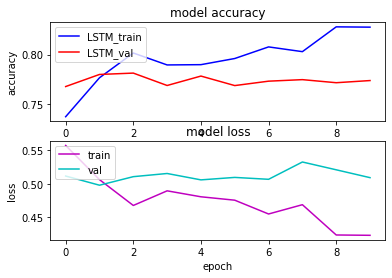

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 5s 171ms/step


### Confusion Matrix


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

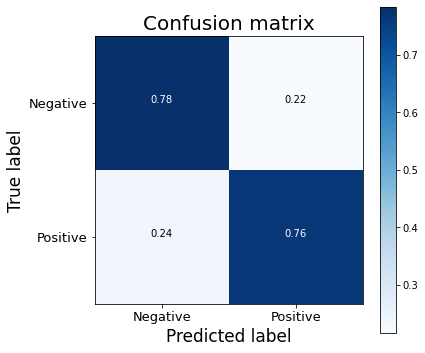

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.77      0.78      0.78    160542
    Positive       0.78      0.76      0.77    159458

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [ ]:
def recognise(text):
    text = preprocess(text)
    x_t = pad_sequences(tokenizer.texts_to_sequences(pd.Series(text)),
                       maxlen = MAX_SEQUENCE_LENGTH)
    scores = model.predict(x_t, verbose=0)
    y_pred = [decode_sentiment(score) for score in scores]
    return y_pred

In [ ]:
recognise("i've finally done it!")

['Positive']

In [ ]:
recognise("i dont like deadlines")

['Negative']